# 01 -  Introduction to OpenQAOA: An example workflow

This section provides a walkthrough of a simple example workflow, and is intended as a quick introduction to the functionalities of the OpenQAOA library. More focused examples are provided in other sections of the documentation.

The QAOA workflow can be divided in four simple steps:
- Problem definition: Define your optimization problem here, either by: 
    - using pre-defined problem classes or,
    - supplying your own QUBO
- Model building: 
    - Build the QAOA circuit with the available configurations
    - Choose the backend (device) to run the circuit
    - Choose the properties of the classical optimizer
- Compile model and optimize: 
    - Compile the model by passing the problem defined in step-1
    - Execute `model.optimize()` to run the optimization process
- Extract results
    - Run `model.results` to obtain information on the optimization run 

### Begin by importing necessary modules

In [1]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems import MaximumCut, NumberPartition

#import the QAOA workflow model
from openqaoa import QAOA

#import method to specify the device
from openqaoa.backends import create_device

ModuleNotFoundError: No module named 'networkx'

### Step 1: Create a problem instance
We begin by creating a problem instance for a simple MaximumCut problem for a random graph created using the python `networkx` module. MaximumCut is a go-to problem to demonstrate QAOA in action.

For this, we first:
- create a random graph using the `networkx` module
- using the MaximumCut problem class, we translate into the QUBO formalism to optimize with QAOA

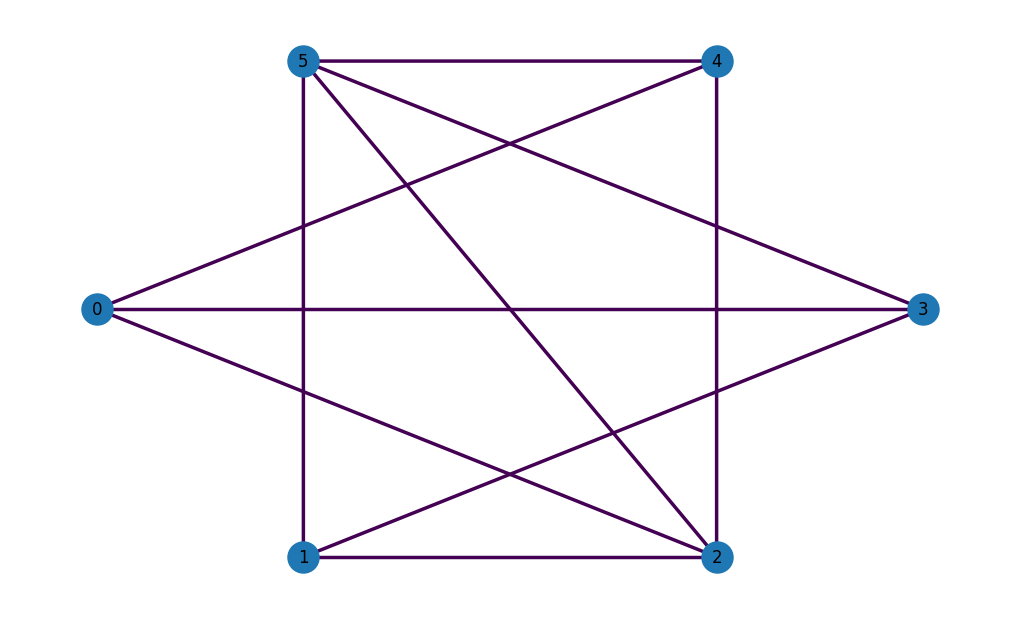

In [2]:
nodes = 6
edge_probability = 0.6
g = nx.generators.fast_gnp_random_graph(n=nodes, p=edge_probability, seed=42)

# import graph plotter from openqaoa
from openqaoa.utilities import plot_graph
plot_graph(g)

In [3]:
# Use the MaximumCut class to instantiate the problem.
maxcut_prob = MaximumCut(g)

# The method `get_qubo_problem()` translates the problem into a binary Qubo problem. 
# The binary values can be access via the `asdict()` method.
maxcut_qubo = maxcut_prob.get_qubo_problem()

In [4]:
pprint(maxcut_qubo.asdict())

{'constant': 0,
 'metadata': {},
 'n': 6,
 'problem_instance': {'G': {'directed': False,
                            'graph': {},
                            'links': [{'source': 0, 'target': 2},
                                      {'source': 0, 'target': 3},
                                      {'source': 0, 'target': 4},
                                      {'source': 1, 'target': 2},
                                      {'source': 1, 'target': 3},
                                      {'source': 1, 'target': 5},
                                      {'source': 2, 'target': 4},
                                      {'source': 2, 'target': 5},
                                      {'source': 3, 'target': 5},
                                      {'source': 4, 'target': 5}],
                            'multigraph': False,
                            'nodes': [{'id': 0},
                                      {'id': 1},
                                      {'id': 2},
             

#### Extract the exact solution for a small enough problem



In [5]:
hamiltonian = maxcut_qubo.hamiltonian

# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -6.0, Solution: ['001110', '110001']


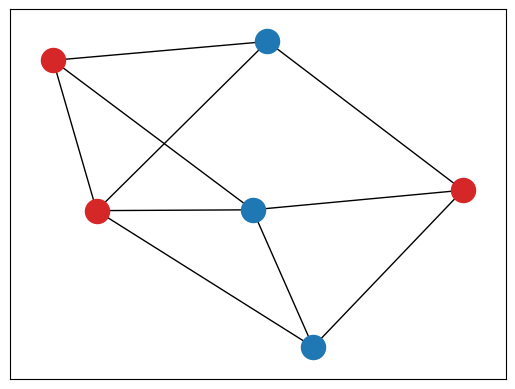

In [6]:
#plot the solution on graph
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)

### Step 2: Build the QAOA model
 - Initialize the model (with default parameters)
 - Optionally set the following properties for the model
     - `model.set_device(...)`: Set the device
         - The device properties include the location of the device `[local, qcs, ibmq]` and the device name. Full list of devices available at              `openqaoa.workflows.parameters.qaoa_parameters.ALLOWED_DEVICES`
     - `model.set_circuit_properties(...)`: Sets the circuit properties. Mainly used for:
         - `p`: the number of layers
         - `param_type`: the desired parameterisation to be chosen between `['standard', 'extended', 'fourier', annealing]`
         - `init_type`: the initialisation strategy for param_type. To be chosen between `['ramp', 'random', 'custom']`
     - `model.set_backend_properties(...)`
     - `model.set_classical_optimizer(...)`


    
For more details on the configurable properties, please refer to the documentation

In [7]:
# initialize model with default configurations
q = QAOA()

In [8]:
# optionally configure the following properties of the model

# device
qiskit_device = create_device(location='local', name='qiskit.statevector_simulator')
q.set_device(qiskit_device)

# circuit properties
q.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

### Step 3: Compile and Optimize

- Once the QAOA model is configured, we need to compile it. **Compilation is necessary** because the QAOA solver has to interact with the problem in to be able to create the underlying QAOA circuit.
- The problem is ready to be optimized now. The user can call `model.optimize()` to initiate the optimization loop. 

In [9]:
q.compile(maxcut_qubo) 

In [10]:
q.optimize()

### Step 4: Accessing the results

In [11]:
opt_results = q.results

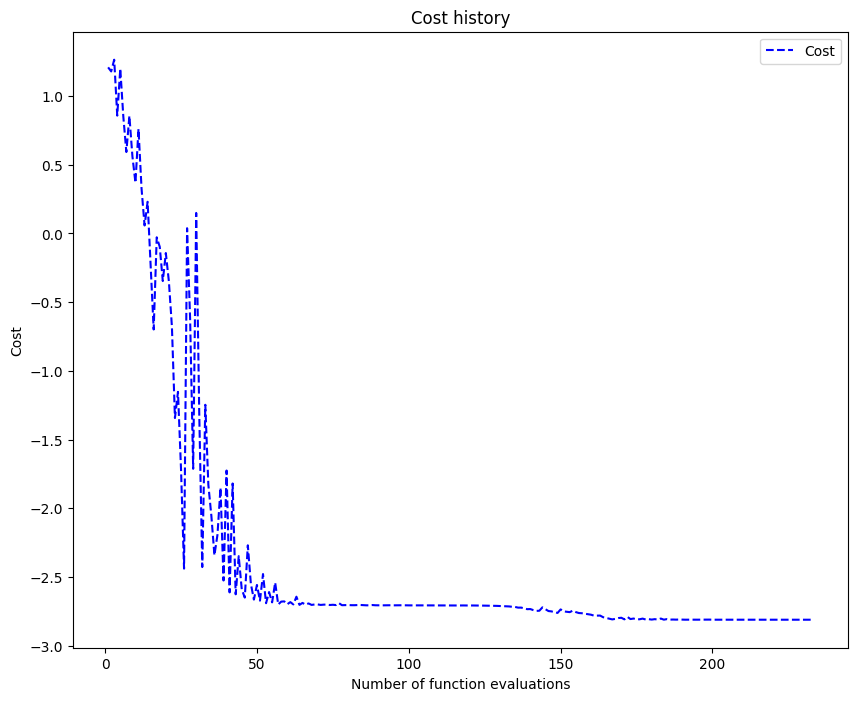

In [12]:
# print the cost history
opt_results.plot_cost()

In [13]:
# prints a large output (commented by default)
# pprint(opt_results.intermediate)

In [14]:
pprint(opt_results.optimized)

{'angles': [1.3376691454094367,
            1.8702720571077855,
            1.7106159414418016,
            1.7265171540852053],
 'cost': -2.8102329416649523,
 'eval_number': 233,
 'job_id': '8b656d30-7c45-46c4-9e2b-47950a744436',
 'measurement_outcomes': array([-0.0092713 -0.00533952j, -0.00087562-0.04750412j,
       -0.03625747-0.03697144j, -0.04129102+0.10079314j,
       -0.0460283 -0.02009872j, -0.03484736+0.06093418j,
       -0.06609874+0.06584512j, -0.08054137+0.16913357j,
       -0.00087562-0.04750412j,  0.0326305 +0.03989333j,
        0.01327079+0.00485964j, -0.02353963+0.12365387j,
       -0.16281772+0.06138876j, -0.07184383+0.13061097j,
       -0.08230322+0.08658721j, -0.06609874+0.06584512j,
       -0.03625747-0.03697144j,  0.01327079+0.00485964j,
       -0.07937384+0.0732019j , -0.17715889+0.16555488j,
       -0.03931647+0.03033797j,  0.006359  +0.07155752j,
       -0.07184383+0.13061097j, -0.03484736+0.06093418j,
       -0.04129102+0.10079314j, -0.02353963+0.12365387j,
   

In [15]:
variational_params = q.optimizer.variational_params

In [16]:
#create the optimized QAOA circuit for qiskit backend
optimized_angles = opt_results.optimized['angles']
variational_params.update_from_raw(optimized_angles)
optimized_circuit = q.backend.qaoa_circuit(variational_params)

#print the optimized QAOA circuit for qiskit backend
optimized_circuit.draw()

┌───┐                                                                  »
q0_0: ┤ H ├─■─────────────────────■──────────────────────────────────────────»
      ├───┤ │                     │                                          »
q0_1: ┤ H ├─┼─────────────────────┼─────────────────────■────────────────────»
      ├───┤ │ZZ(3.4212318828836)  │                     │ZZ(3.4212318828836) »
q0_2: ┤ H ├─■─────────────────────┼─────────────────────■────────────────────»
      ├───┤                       │ZZ(3.4212318828836)                       »
q0_3: ┤ H ├───────────────────────■──────────────────────────────────────────»
      ├───┤                                                                  »
q0_4: ┤ H ├──────────────────────────────────────────────────────────────────»
      ├───┤                                                                  »
q0_5: ┤ H ├──────────────────────────────────────────────────────────────────»
      └───┘                                                                  »
«                            ┌───────────────────────┐                      »
«q0_0: ─■────────────────────┤ Rx(-2.67533829081887) ├──────────────────────»
«       │                    └───────────────────────┘                      »
«q0_1: ─┼───────────────────────■──────────────────────■────────────────────»
«       │                       │                      │                    »
«q0_2: ─┼───────────────────────┼──────────────────────┼────────────────────»
«       │                       │ZZ(3.4212318828836)   │                    »
«q0_3: ─┼───────────────────────■──────────────────────┼────────────────────»
«       │ZZ(3.4212318828836)                           │                    »
«q0_4: ─■──────────────────────────────────────────────┼────────────────────»
«                                                      │ZZ(3.4212318828836) »
«q0_5: ────────────────────────────────────────────────■────────────────────»
«                                                                           »
«                                                                              »
«q0_0: ────────────────────────────────────────────────────────────────────────»
«      ┌───────────────────────┐                                               »
«q0_1: ┤ Rx(-2.67533829081887) ├───────────────────────────────────────────────»
«      └───────────────────────┘                      ┌───────────────────────┐»
«q0_2: ───■──────────────────────■────────────────────┤ Rx(-2.67533829081887) ├»
«         │                      │                    └───────────────────────┘»
«q0_3: ───┼──────────────────────┼───────────────────────■─────────────────────»
«         │ZZ(3.4212318828836)   │                       │                     »
«q0_4: ───■──────────────────────┼───────────────────────┼─────────────────────»
«                                │ZZ(3.4212318828836)    │ZZ(3.4212318828836)  »
«q0_5: ──────────────────────────■───────────────────────■─────────────────────»
«                                                                              »
«                                                        »
«q0_0: ──■────────────────────────■──────────────────────»
«        │                        │                      »
«q0_1: ──┼────────────────────────┼──────────────────────»
«        │ZZ(3.45303430817041)    │                      »
«q0_2: ──■────────────────────────┼──────────────────────»
«      ┌───────────────────────┐  │ZZ(3.45303430817041)  »
«q0_3: ┤ Rx(-2.67533829081887) ├──■──────────────────────»
«      └───────────────────────┘┌───────────────────────┐»
«q0_4: ───■─────────────────────┤ Rx(-2.67533829081887) ├»
«         │ZZ(3.4212318828836)  ├───────────────────────┤»
«q0_5: ───■─────────────────────┤ Rx(-2.67533829081887) ├»
«                               └───────────────────────┘»
«                                                    ┌───────────────────────┐»
«q0_0: ────────────────────────■─────────────────────┤ Rx(-3.7405